<a href="https://colab.research.google.com/github/AvishneelNarayan/ADS2002-anar0025/blob/main/ImplementingCNN_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Convolutional Neural Network (CNN)

## Contents

* Import packages
* Import CIFAR data
* Create CNN
* Train model and check results
* Extensions
* Exercises

In the previous notebook we looked at the underlying concepts of Convolutional Neural Networks (CNNs). In this notebook we demonstrate how to build and train a simple CNN to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). This uses the Keras Sequential model, which we have previously used for building Dense Neural Networks.

This notebook will introduce:
* Setup of two-dimensional convolutional and max-pooling layers.
* Connecting convolutional layers to dense layers.
* Extensions for improving the performance of CNNs.


## Import packages

Again we import Tensorflow and Keras for creating and running the Neural Networks. We also import `matplotlib`, `numpy` and `sklearn` for the analysis of the results.

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

We create a function for calculating and plotting confusion matrices.

In [2]:
def plt_confusion_matrix(Y_test, y_pred, categories, method):
    """
    Given actual target values and predicted values for a classifier 'method',
    plots the confusion matrix with a listing of the categories
    """
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    cnf_matrix = confusion_matrix(Y_test, y_pred) # create a confusion matrix for our actual and predicted values
    # write the confusion matrix to a dataframe with row and column names as the categories, which are already defined
    cmatrix = pd.DataFrame(cnf_matrix,columns=categories,index=categories)
    f, ax = plt.subplots(figsize=(7,6)) # initialise the plots and axes
    sns.heatmap(cmatrix, annot=True, linewidths=.5, annot_kws={"size":7}) # plot the confusion matrix as a heatmap
    plt.title('Confusion matrix for '+method) # add a title, + concatenates two strings
    plt.ylabel('Actual label') # add a ylabel
    plt.xlabel('Predicted label') # add a xlabel
    # adjust the bottom and top of the figure, so we can view all of it
    bottom, top = ax.get_ylim()  # get the y axis limits
    ax.set_ylim(bottom + 0.5, top - 0.5); # adjust the y axis limits

## Import CIFAR10 data

The CIFAR10 dataset, which is built in to Keras, contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
(train_images_full, train_labels_full), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images_full, test_images = train_images_full / 255.0, test_images / 255.0
val_images = train_images_full[:5000]
val_labels = train_labels_full[:5000]
train_images = train_images_full[5000:]
train_labels = train_labels_full[5000:]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


To verify that the dataset looks correct, we plot the first 25 images from the training set and display the class name below each image:


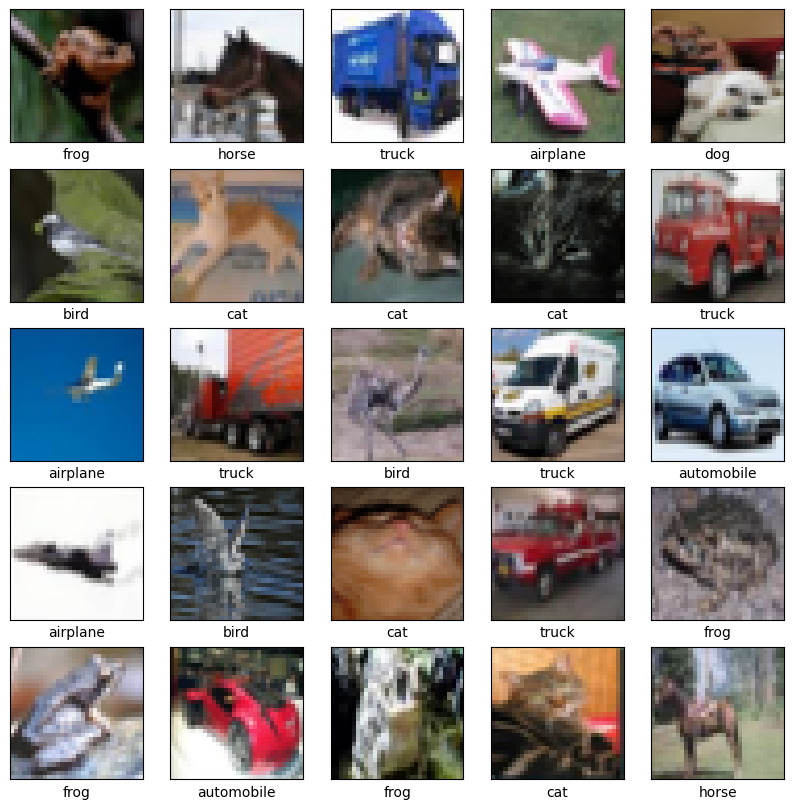

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Create CNN

The seven lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. The color_channels here refers to (R,G,B). In this example, we configure the CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. We can do this by making the first layer the input shape. The following layers do not need to have the input specified, as this is passed from the previous layer.

For all these layers we use padding on the boundaries, which corresponds to the argument `padding="same"`.

Here the structure of the CNN is:
* The input is passed to a two-dimensional convolution with 16 convolutions of size `3x3`. This is then passed through the ReLU activation function. The output of this layer will have shape (32,32,16).
* This layer is passed to a max-pooling layer with windows of size `2x2`. The output of this layer will have shape (16,16,16).
* The layer is passed to a two-dimensional convolution with 32 convolutions of size `3x3`. This is then passed through the ReLU activation function. The output of this layer will have shape (16,16,32).
* This layer is passed to a max-pooling layer with windows of size `2x2`. The output of this layer will have shape (8,8,32).
* The layer is passed to a two-dimensional convolution with 64 convolutions of size `3x3`. This is then passed through the ReLU activation function. The output of this layer will have shape (8,8,64).



In [5]:
model = models.Sequential()
model.add(layers.Input(shape=(32,32,3,)))
model.add(layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2), padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))

We can display the architecture of the model so far:

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,584 (92.12 KB)

 Trainable params: 23,584 (92.12 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

To complete the model, we feed the last output tensor from the convolutional base (of shape (8, 8, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we need to flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. These Dense layers can include `Dropout` layers, as in the example below. CIFAR has 10 output classes, so the final Dense layer has 10 outputs.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))

The complete architecture of the model is now:

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089,514 (4.16 MB)

 Trainable params: 1,089,514 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (8, 8, 64) outputs of the last Convolution layer were flattened into vectors of shape (4096) before going through three Dense layers.

We can also see that the majority of the model parameters, and therefore the computational cost, is associated with the first Dense layer.

### Train model and check results

We can now train the model using the `Adam` optimizer. As this is a multi-classification problem the appropriate loss function is Sparse Categorical Crossentropy, which is calculated from the probabilities output from the final Dense layer.

We train the model for 20 epochs, by which time the validation accuracy seems to have settled.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20,
                    validation_data=(val_images, val_labels))

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2703 - loss: 1.9449 - val_accuracy: 0.4876 - val_loss: 1.3970
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5030 - loss: 1.3854 - val_accuracy: 0.6102 - val_loss: 1.0914
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5859 - loss: 1.1841 - val_accuracy: 0.6292 - val_loss: 1.0662
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6320 - loss: 1.0602 - val_accuracy: 0.6742 - val_loss: 0.9517
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6700 - loss: 0.9772 - val_accuracy: 0.6922 - val_loss: 0.8935
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6932 - loss: 0.8931 - val_accuracy: 0.6940 - val_loss: 0.8936
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7126 - loss: 0.8456 - val_accuracy: 0.7032 - val_loss: 0.8714
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7346 - loss: 0.7816 -

We can now evaluate the model by investigating a number of measures. First we plot the evolution of the accuracy and validation accuracy. The accuracy continues to increase towards one, however the validation accuracy has settled after approximately 10 epochs, indicating that the model approached an optimal state.

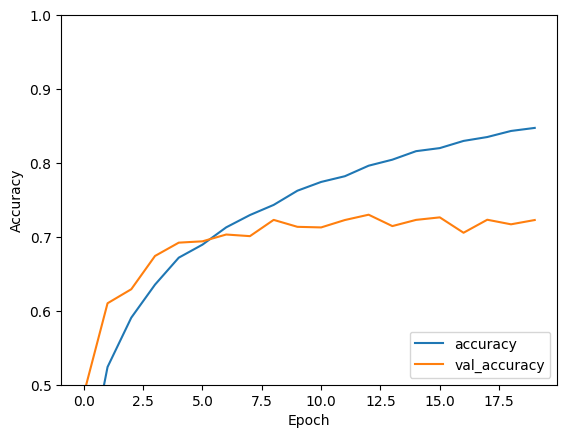

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [11]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
print(f" Test loss is {test_loss:.4f}, test accuracy is {test_acc:.4f}")

 Test loss is 1.0675, test accuracy is 0.7177


This simple CNN has achieved a test accuracy of over 70%, which is not bad for a few lines of code.

We can investigate the errors in more detail by plotting the confusion matrix. Here we see the main errors are animals being mislabeled. Given the resolution of the images, this is not surprising.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


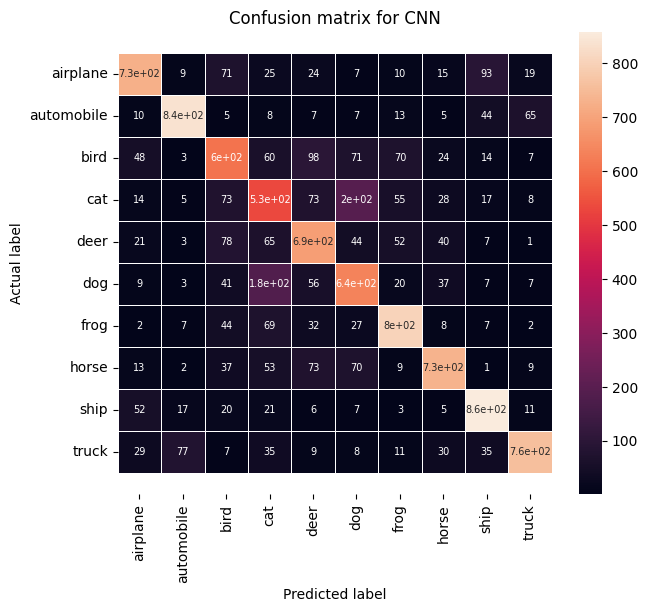

In [12]:
y_probs = model.predict(test_images)
y_pred = np.argmax(y_probs, axis=1)
plt_confusion_matrix(test_labels, y_pred, class_names, 'CNN')

Again, this is apparent from the classification report, where birds, cats and dogs have the lowest scores.

In [13]:
print(classification_report(test_labels, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.79      0.73      0.76      1000
  automobile       0.87      0.84      0.85      1000
        bird       0.62      0.60      0.61      1000
         cat       0.51      0.53      0.52      1000
        deer       0.65      0.69      0.67      1000
         dog       0.59      0.64      0.61      1000
        frog       0.77      0.80      0.78      1000
       horse       0.79      0.73      0.76      1000
        ship       0.79      0.86      0.82      1000
       truck       0.85      0.76      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



## Extensions

One problem with deep CNNs is that noise outweighs the signal in the backpropagation algorithm. This is known as the _vanishing gradients_ problem.Three common extensions for improving the performance of CNNs are:
* [Residual connections](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec),
* [Batch normalization](https://medium.com/@sanjay_dutta/understanding-the-batch-normalization-ffac49532367),
* [Depthwise separable convolutions](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec).

## Exercises

Create a CNN for the MNIST dataset which was introduced in [Further Neural Networks](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Neural%20Networks/FurtherNeuralNetworks.ipynb). Use the same data split, as used in that notebook.

Your CNN should have:
* Convolution layer with 8 filters.
* Max-pooling layer with `2x2` windows.
* Convolution layer with 16 filters.
* Max-pooling layer with `2x2` windows.
* Flatten layer.
* Dense layer with 64 nodes.
* Dropout layer with a dropout of 0.5.
* Classification layer.

Use padding for your CNN and the same compilation and training parameters as for the CNN considered in this notebook.

Print a summary of the model.

Train the model and plot the evolution of the accuracy and validation accuracy.

In [20]:
(train_images_full, train_labels_full), (test_images, test_labels) = datasets.mnist.load_data()

train_images_full, test_images = train_images_full / 255.0, test_images / 255.0

train_images_full = train_images_full.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

val_images = train_images_full[:5000]
val_labels = train_labels_full[:5000]
train_images = train_images_full[5000:]
train_labels = train_labels_full[5000:]

In [21]:
model = models.Sequential()

model.add(layers.Input(shape=(28, 28, 1)))

model.add(layers.Conv2D(8, (3, 3),
                        activation='relu',
                        padding='same'))

model.add(layers.MaxPooling2D((2, 2),
                              padding='same'))

model.add(layers.Conv2D(16, (3, 3),
                        activation='relu',
                        padding='same'))

model.add(layers.MaxPooling2D((2, 2),
                              padding='same'))

model.add(layers.Flatten())

model.add(layers.Dense(64,
                       activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(10))

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,138 (203.66 KB)

 Trainable params: 52,138 (203.66 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
history = model.fit(train_images,
                    train_labels,
                    epochs=20,
                    validation_data=(val_images, val_labels))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7700 - loss: 0.7081 - val_accuracy: 0.9718 - val_loss: 0.0986
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9471 - loss: 0.1796 - val_accuracy: 0.9812 - val_loss: 0.0661
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9605 - loss: 0.1344 - val_accuracy: 0.9842 - val_loss: 0.0581
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9669 - loss: 0.1092 - val_accuracy: 0.9862 - val_loss: 0.0540
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9708 - loss: 0.0971 - val_accuracy: 0.9852 - val_loss: 0.0503
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9735 - loss: 0.0856 - val_accuracy: 0.9876 - val_loss: 0.0501
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9750 - loss: 0.0801 - val_accuracy: 0.9878 - val_loss: 0.0446
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9769 - loss: 0.0742 -

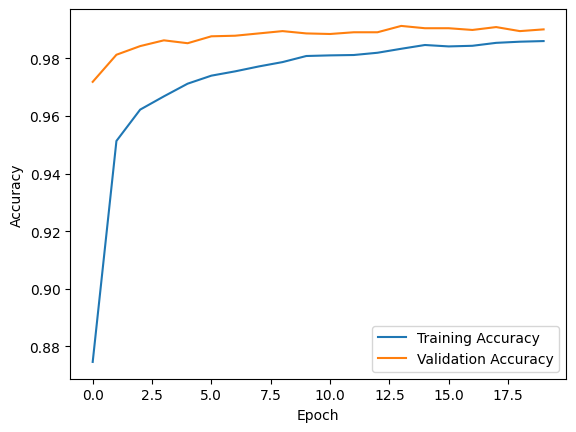

In [25]:
plt.plot(history.history['accuracy'],
         label='Training Accuracy')

plt.plot(history.history['val_accuracy'],
         label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(test_images,
                                     test_labels,
                                     verbose=0)

print(f"Test loss is {test_loss:.4f}, test accuracy is {test_acc:.4f}")

Test loss is 0.0325, test accuracy is 0.9906
